<a href="https://colab.research.google.com/github/kpetras/ImageFun/blob/main/MutualInfoImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat



#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")


Load the images 

In [ ]:
#mount your google drive 
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


(600, 600)

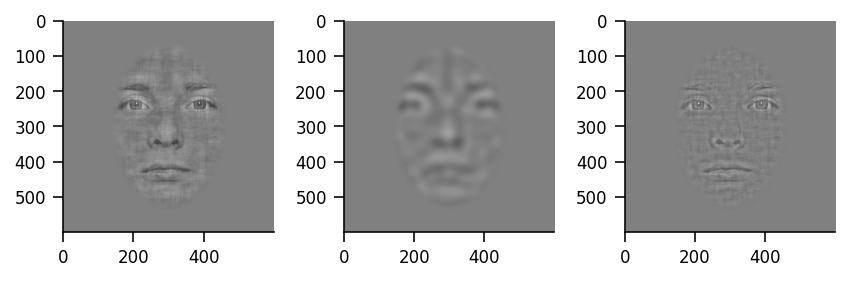

In [ ]:
BB=plt.imread('/content/gdrive/MyDrive/RetMEG/new/11__Stim_010.bmp')

LSF=plt.imread('/content/gdrive/MyDrive/RetMEG/new/12___Stim_010.bmp')

HSF=plt.imread('/content/gdrive/MyDrive/RetMEG/new/13___Stim_010.bmp')


f, axarr = plt.subplots(1,3)
axarr[0].imshow(BB, cmap='gray', vmin=0, vmax=255)
axarr[1].imshow(LSF, cmap='gray', vmin=0, vmax=255)
axarr[2].imshow(HSF, cmap='gray', vmin=0, vmax=255)
LSF.shape    

In [ ]:
#import all images
import glob


In [ ]:
#make separate arrays for all conditions
for ii in range (47):
  BBims = glob.glob('/content/gdrive/MyDrive/RetMEG/new/' + '11_*')
  LSFims = glob.glob('/content/gdrive/MyDrive/RetMEG/new/' + '12_*')
  HSFims = glob.glob('/content/gdrive/MyDrive/RetMEG/new/' + '13_*')
  BBscrims = glob.glob('/content/gdrive/MyDrive/RetMEG/new/' + '21_*')
  LSFscrims = glob.glob('/content/gdrive/MyDrive/RetMEG/new/' + '22_*')
  HSFscrims = glob.glob('/content/gdrive/MyDrive/RetMEG/new/' + '23_*')

In [ ]:
#plot histograms of example images
fig, axes = plt.subplots(1, 2)
axes[0].hist(LSF.ravel(), bins=30)
axes[0].set_title('LSF histogram')
axes[1].hist(HSF.ravel(), bins=30)
axes[1].set_title('HSF histogram')

0.07297372460341572

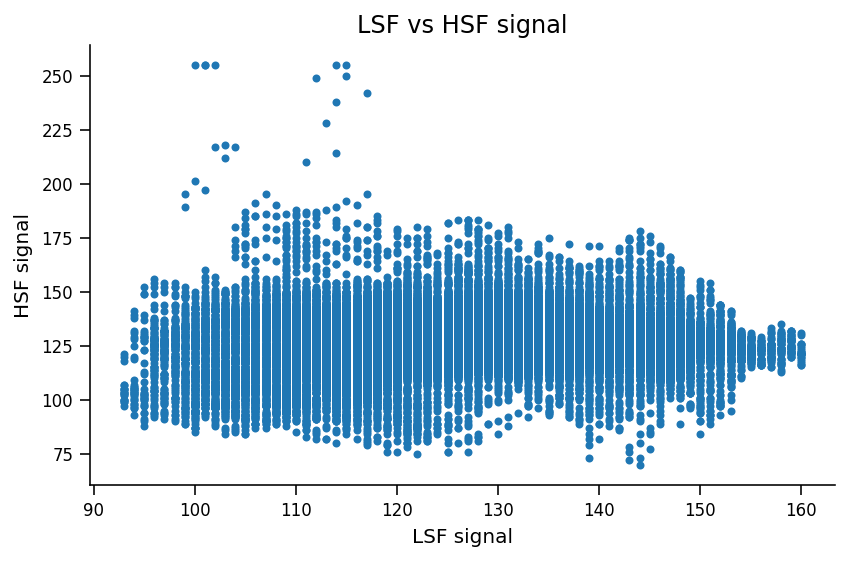

In [ ]:
plt.plot(LSF.ravel(), HSF.ravel(), '.')
plt.xlabel('LSF signal')
plt.ylabel('HSF signal')
plt.title('LSF vs HSF signal')
np.corrcoef(LSF.ravel(), HSF.ravel())[0, 1]

Text(0, 0.5, 'HSF signal bin')

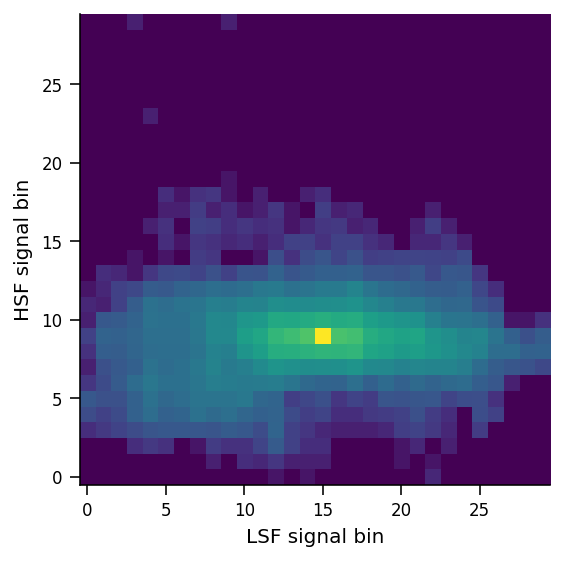

In [ ]:
#plot 2d hist for example image pair
hist_2d, x_edges, y_edges = np.histogram2d(
    LSF.ravel(),
    HSF.ravel(),
    bins=30)
# Show log histogram, avoiding divide by 0
hist_2d_log = np.zeros(hist_2d.shape)
non_zeros = hist_2d != 0
hist_2d_log[non_zeros] = np.log(hist_2d[non_zeros])
plt.imshow(hist_2d_log.T, origin='lower')
plt.xlabel('LSF signal bin')
plt.ylabel('HSF signal bin')

Mutual information is a metric from the joint (2D) histogram. The metric is high when the signal is highly concentrated in few bins (squares), and low when the signal is spread across many bins (squares).

Mutual information is defined as:
I(X;Y)=∑y∈Y∑x∈Xp(x,y)log(p(x,y)p(x)p(y))

In [ ]:
def mutual_information(hgram):
    """ Mutual information for joint histogram
    """
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

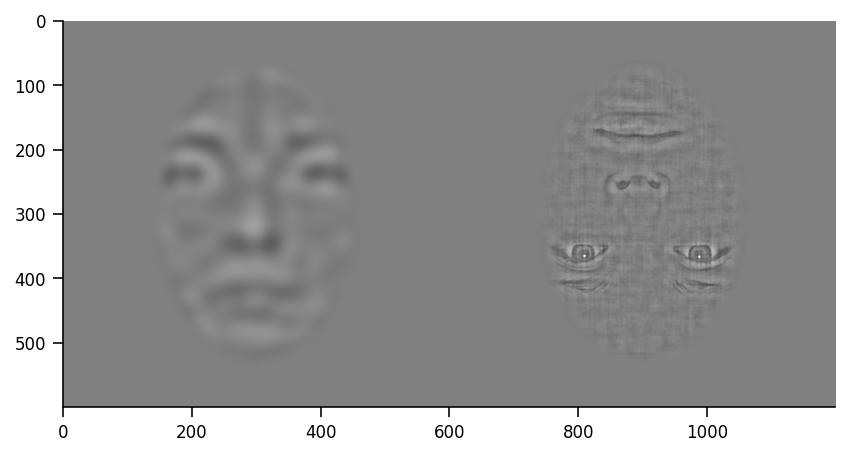

In [ ]:
HSF_moved = np.zeros(HSF.shape)
HSF_moved = np.flipud(HSF)
plt.imshow(np.hstack((LSF, HSF_moved)),cmap='gray', vmin=0, vmax=255)
hist_2d_moved, x_edges, y_edges = np.histogram2d(
    LSF.ravel(),
    HSF_moved.ravel(),
    bins=20)

# Show log histogram, avoiding divide by 0
hist_2d_moved_log = np.zeros(hist_2d_moved.shape)
non_zeros = hist_2d_moved != 0
hist_2d_moved_log[non_zeros] = np.log(hist_2d_moved[non_zeros])

In [ ]:
print(mutual_information(hist_2d))
print(mutual_information(hist_2d_moved))

0.22146980667517413
0.13314169520548153


In [ ]:
#make moving window of MI and step through images with step size==1 for example image
window = 50
MI_image = np.zeros([LSF.shape[0] - window -1,LSF.shape[0] - window -1])
for horstep in range (LSF.shape[0] - window -1) :
  for vertstep in range (LSF.shape[0] - window -1) :
    imbin1=LSF[horstep:horstep+window,vertstep:vertstep+window]
    imbin2=HSF[horstep:horstep+window,vertstep:vertstep+window]
    #get histogram for current window
    hist_2d, x_edges, y_edges = np.histogram2d(
    imbin1.ravel(),
    imbin2.ravel(),
    bins=20)
    thisbin = mutual_information(hist_2d)
    MI_image[horstep,vertstep]=thisbin
plt.imshow(MI_image)
plt.colorbar()

In [ ]:
#loop over images to get individual MI arrays and then average over those
window = 50
MI_image = np.zeros([47,LSF.shape[0] - window -1,LSF.shape[0] - window -1])

for ii in range (47):
  LSF= plt.imread(LSFims[ii])
  HSF= plt.imread(HSFims[ii])
  for horstep in range (LSF.shape[0] - window -1) :
    for vertstep in range (LSF.shape[0] - window -1) :
      imbin1=LSF[horstep:horstep+window,vertstep:vertstep+window]
      imbin2=HSF[horstep:horstep+window,vertstep:vertstep+window]
      #get histogram for current window
      hist_2d, x_edges, y_edges = np.histogram2d(
      imbin1.ravel(),
      imbin2.ravel(),
      bins=20)
      thisbin = mutual_information(hist_2d)
      MI_image[ii,horstep,vertstep]=thisbin
#average over MI_image


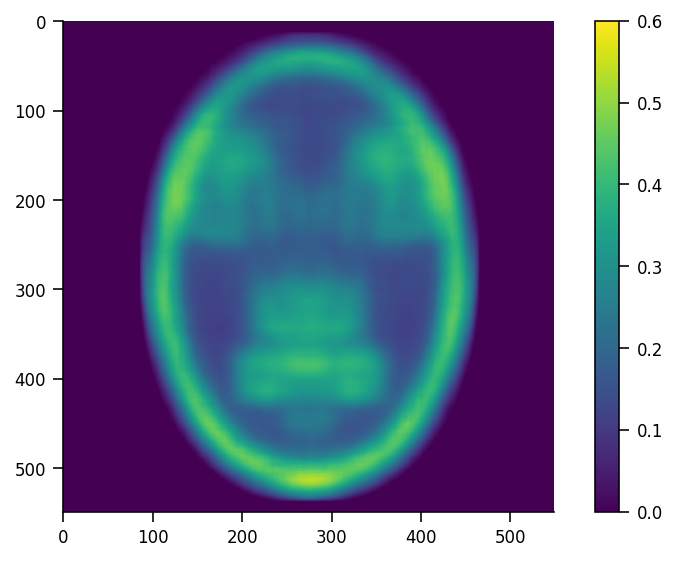

In [ ]:
MI_avg = np.mean(MI_image,0)
plt.imshow(MI_avg, vmin=0, vmax=0.6)
plt.colorbar()
plt.savefig('/content/gdrive/MyDrive/RetMEG/MI_intact.eps', format='eps')

In [ ]:
#same thing for scrambled
#loop over images to get individual MI arrays and then average over those
window = 50
MI_scrimage = np.zeros([47,LSF.shape[0] - window -1,LSF.shape[0] - window -1])

for ii in range (47):
  LSFscr= plt.imread(LSFscrims[ii])
  HSFscr= plt.imread(HSFscrims[ii])
  for horstep in range (LSFscr.shape[0] - window -1) :
    for vertstep in range (LSFscr.shape[0] - window -1) :
      imbin1=LSFscr[horstep:horstep+window,vertstep:vertstep+window]
      imbin2=HSFscr[horstep:horstep+window,vertstep:vertstep+window]
      #get histogram for current window
      hist_2d, x_edges, y_edges = np.histogram2d(
      imbin1.ravel(),
      imbin2.ravel(),
      bins=20)
      thisbin = mutual_information(hist_2d)
      MI_scrimage[ii,horstep,vertstep]=thisbin


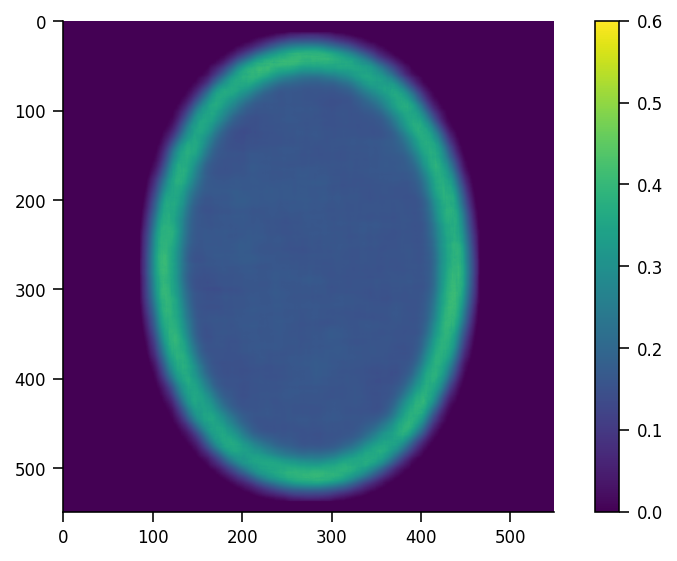

In [ ]:
#average over MI_image
MIscr_avg = np.mean(MI_scrimage,0)
plt.imshow(MIscr_avg, vmin=0, vmax=0.6)
plt.colorbar()
plt.savefig('/content/gdrive/MyDrive/RetMEG/MI_scrambled.eps', format='eps')

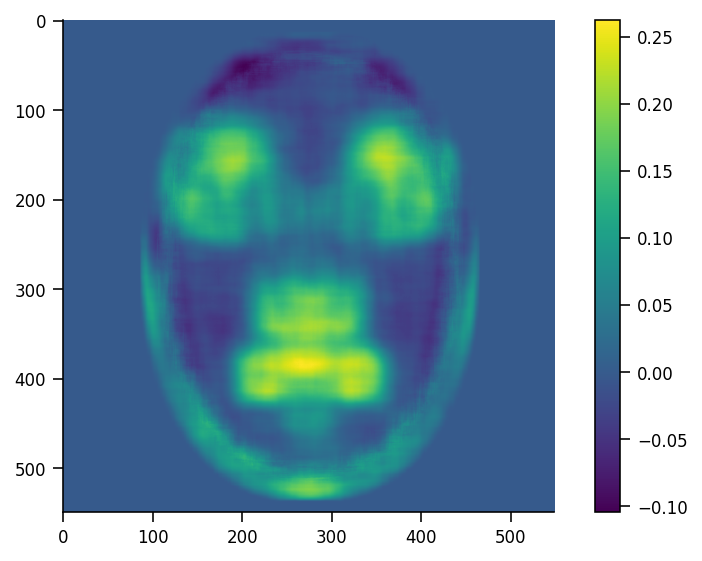

In [ ]:
diff = MI_avg - MIscr_avg
plt.imshow(diff)
plt.colorbar()
plt.savefig('/content/gdrive/MyDrive/RetMEG/MI_IntminScr.eps', format='eps')

In [1]:
#calculate entropy for each image
for ii in range (47):
  LSF= plt.imread(LSFims[ii])
  HSF= plt.imread(HSFims[ii])
  BB= plt.imread(BBims[ii])
  marg = np.histogramdd(np.ravel(LSF), bins = 256)[0]/img.size
  marg = list(filter(lambda p: p > 0, np.ravel(marg)))
  entropyLSF[ii] = -np.sum(np.multiply(marg, np.log2(marg)))

  marg = np.histogramdd(np.ravel(HSF), bins = 256)[0]/img.size
  marg = list(filter(lambda p: p > 0, np.ravel(marg)))
  entropyHSF[ii] = -np.sum(np.multiply(marg, np.log2(marg)))

  marg = np.histogramdd(np.ravel(BB), bins = 256)[0]/img.size
  marg = list(filter(lambda p: p > 0, np.ravel(marg)))
  entropyBB[ii] = -np.sum(np.multiply(marg, np.log2(marg)))

print(mean(entropyLSF))
print(mean(entropyHSF))
print(mena(entropyBB))

NameError: ignored